# Analisi dei consumi energetici anello di teleriscaldamento
calcolo per simulatore consumi energetici

In [201]:
import pandas as pd 
import datetime 
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import numpy as np

## Caricamento dei dati

### Caricamento dati da CLOE Energyteams

In [202]:
data = pd.read_csv("Te_riscPad_31122022071231.csv",
                 sep = ";",
                 skiprows = 2,
                 usecols=["day","time", "(D)Energia Termica Edificio D", "Temperatura Ambiente"])

data.columns = ["day", "time", "temp", "energy"]
data['day_time'] = pd.to_datetime(data['day'] + data['time'], format='%d-%m-%Y%H:%M:%S')
data['energy'] = data.energy/1000
data

,day,time,temp,energy,day_time
0,01-01-2018,00:00:00,0.00,0.0,2018-01-01 00:00:00
1,01-01-2018,01:00:00,0.00,0.0,2018-01-01 01:00:00
2,01-01-2018,02:00:00,0.00,0.0,2018-01-01 02:00:00
3,01-01-2018,03:00:00,0.00,0.0,2018-01-01 03:00:00
4,01-01-2018,04:00:00,0.00,0.0,2018-01-01 04:00:00
...,...,...,...,...,...
43795,30-12-2022,19:00:00,10.82,2.0,2022-12-30 19:00:00
43796,30-12-2022,20:00:00,10.82,0.0,2022-12-30 20:00:00
43797,30-12-2022,21:00:00,10.82,7.5,2022-12-30 21:00:00
43798,30-12-2022,22:00:00,10.82,52.0,2022-12-30 22:00:00


In [203]:
# crea nuove colonne anno, mese, giorno, giorno della settimana e dell'anno
data['year'] =  data.day_time.dt.year
data['month'] = data.day_time.dt.month 
data['dd'] =    data.day_time.dt.day 
data['dw'] =    data.day_time.dt.day_of_week +1
data['dy'] =    data.day_time.dt.day_of_year
data['hh'] =    data.day_time.dt.hour

### Definizione dei prezzi 

In [204]:
prezzo_min = 0.20
prezzo_med = 0.30
prezzo_max = 0.40

## Simulazione delle temperature

4368


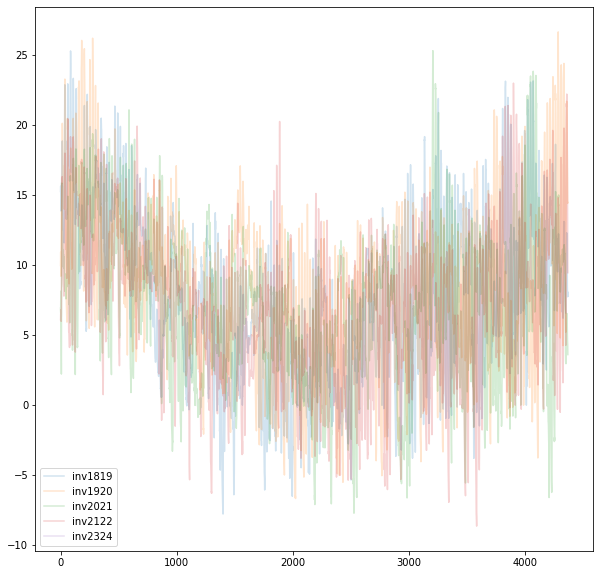

In [205]:
data['stagione'] = "-"
anni = [2018,2019,2020,2021,2022,2023]
stagioni = ["inv1819" ,"inv1920" ,"inv2021" ,"inv2122", "inv2223","inv2324"]

tempinv = pd.DataFrame( columns = stagioni ) 
nn = 182*24
print(nn)
nulls = list(["NaN"]*nn) 

for i in range(0,5):
    data.loc[ (data.year == anni[i])   & (data.dy > 287) , "stagione"] = stagioni[i]  
    data.loc[ (data.year == anni[i]+1) & (data.dy < 106) , "stagione"] = stagioni[i]
    x =  data.loc[ data.stagione == stagioni[i] ].temp.head(nn).to_list()
    x = x + nulls
    tempinv[ stagioni[i] ] = x[0:nn]

tempinv.reset_index(inplace=True)
tempinv['week'] = tempinv['index'] // (7*24)
tempinv.drop(columns=["index"], inplace=True)  
tempinv[stagioni].plot(alpha = .2)
nsim = 200
cols = ["sim"+ str(i) for i in range(1,nsim+1)]

tempinv_sim = pd.DataFrame(columns = cols)
 
for s in range(0,nsim):
    x = []
    for w in range(1,26):
        weeklytemp = tempinv[ tempinv.week == w] 
        i = random.randint(0,3)
        x = x + weeklytemp[ stagioni[ i ] ].to_list()
    tempinv_sim[cols[s]] = x
         
tempinv.to_csv("temperature_misurate.csv")
tempinv_sim.to_csv("temperature_simulate.csv")


## Simulazione della regolazione dell'impianto

Definizione del lavorativoime di funzionamento
iniziamo con una suddivisione in due gruppi: 
- attivo a 20°C nominali
- attenuazione notturna e festiva

In [206]:
def imposta_ferie(data):
    data.loc[  data.dw >= 6 , "ferie"                                         ] = True   
    data.loc[ (data.month == 1 ) &  data.day.isin( (1,2,3,4,5,6)) , "ferie"   ] = True
    data.loc[ (data.month == 11) &  data.day.isin( (2,3,4)) , "ferie"         ] = True
    data.loc[ (data.month == 12) &  data.day.isin( (24,25,26,31)) , "ferie"   ] = True
    return data.ferie

In [207]:

data['ferie'] = False
data['ferie'] = imposta_ferie(data)

# orario lavorativo  
data['lavorativo'] =    False
data.loc[ (data.hh >= 6 ) &  (data.hh <= 18 ) , 'lavorativo']= True
data.loc[ (data.ferie == True) , 'lavorativo']= False

data['dotcolor'] = ["red" if we==True else "blue" for we in data.ferie]


<AxesSubplot:>

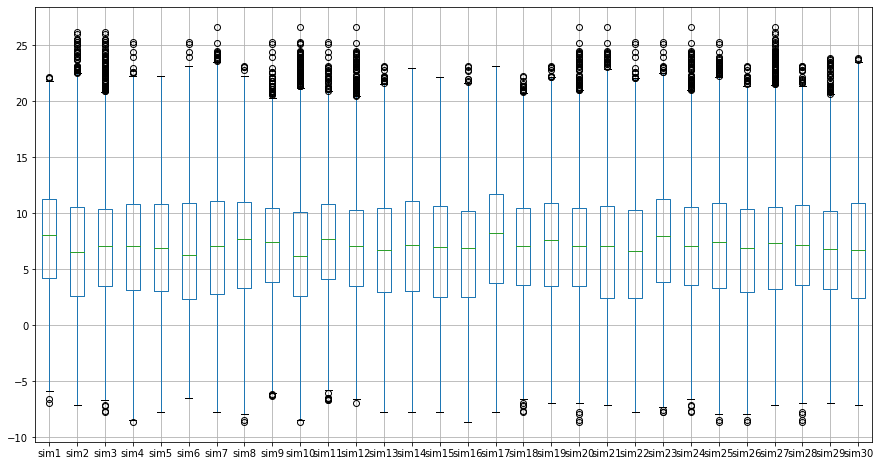

In [208]:
tempinv_sim[cols[0:30]].boxplot(figsize=(15,8))

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

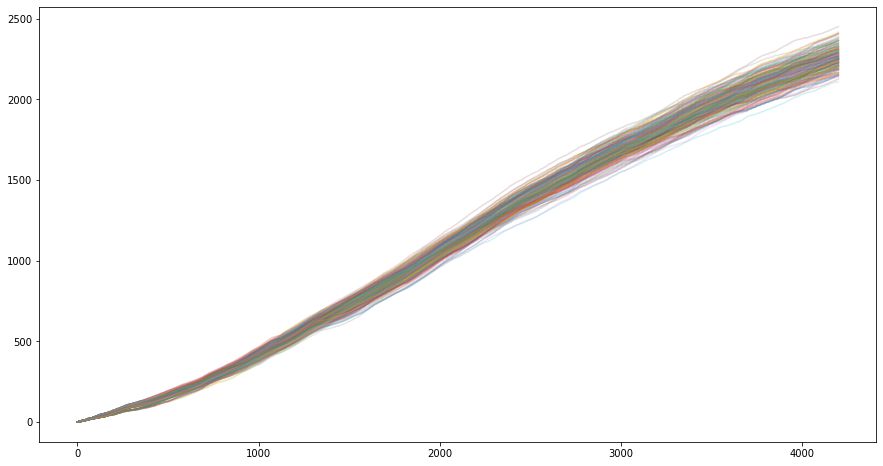

In [209]:
#gg simulati
sim_gg = pd.DataFrame(columns = cols)

for c in cols: 
    te = tempinv_sim[c].copy()
    te[ te > 20 ] = 20
    dt = 20 - te
    sim_gg[c] = dt.cumsum() / 24

plt.figure()  
sim_gg.plot(legend = False, figsize=(15,8), alpha = .2)

(array([ 3., 12., 25., 36., 45., 37., 21., 12.,  7.,  2.]),
 array([2109.56583333, 2143.750125  , 2177.93441667, 2212.11870833,
        2246.303     , 2280.48729167, 2314.67158333, 2348.855875  ,
        2383.04016667, 2417.22445833, 2451.40875   ]),
 <BarContainer object of 10 artists>)

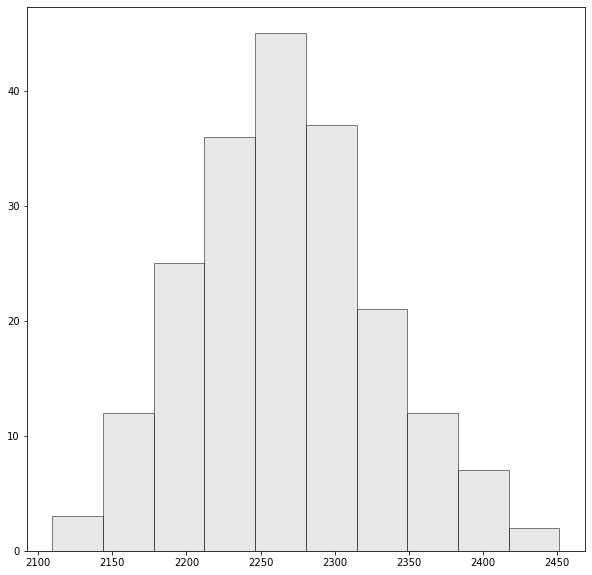

In [210]:
gg_simulati_inizio = sim_gg.tail(1).values.tolist()[0]
plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = 0.5 )

In [211]:
# intrvallo di confidenza
gg_simulati_inizio.sort() 
xs = [round(x) for x in gg_simulati_inizio] 
print("minimo", xs[0] , " -  massimo", xs[99], "gradi giorno")
print("mediana: ", xs[50] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[94], "gradi giorno")

minimo 2110  -  massimo 2264 gradi giorno
mediana:  2227 gradi giorno
intervallo di confidenza al 90%:  2148  -  2258 gradi giorno


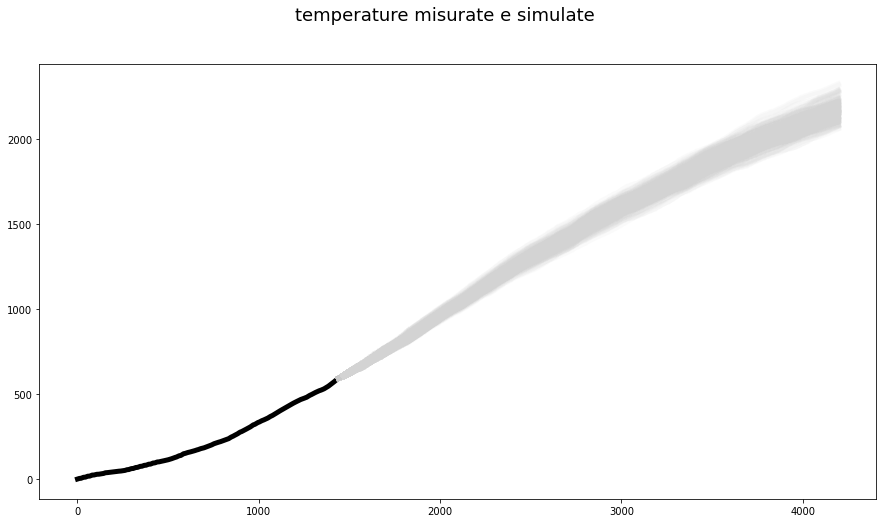

In [212]:
# serie composta da una parte misurata e una stimata
sim_gg_misti = pd.DataFrame(columns = cols)

limite =60*24
temp_misurate = tempinv["inv2223"]
temp_misurate = temp_misurate[0:limite].values
temp_misurate = [float(i) for i in temp_misurate]

for c in cols: 
    temp_simulate = tempinv_sim[c][limite+1:4199].values 
    temp_simulate = [float(i) for i in temp_simulate]
    te =  [  *temp_misurate , *temp_simulate ]
    te = [x if x < 20 else 20 for x in te]
    dt = [20 - x for x in te]
    sim_gg_misti[c] = pd.Series(dt).cumsum() / 24





plt.figure( figsize=(15,8))  
plt.plot(sim_gg_misti[0:limite].sim1,  alpha = 1, color = "black", linewidth=5)
plt.plot(sim_gg_misti[limite:4199],  alpha = .1, color = "lightgray", linewidth=5)
plt.suptitle('temperature misurate e simulate', fontsize=18)
plt.show()

(array([12., 20., 29., 35., 42., 30., 17.,  5.,  8.,  2.]),
 array([2061.45875   , 2088.01833333, 2114.57791667, 2141.1375    ,
        2167.69708333, 2194.25666667, 2220.81625   , 2247.37583333,
        2273.93541667, 2300.495     , 2327.05458333]),
 <BarContainer object of 10 artists>)

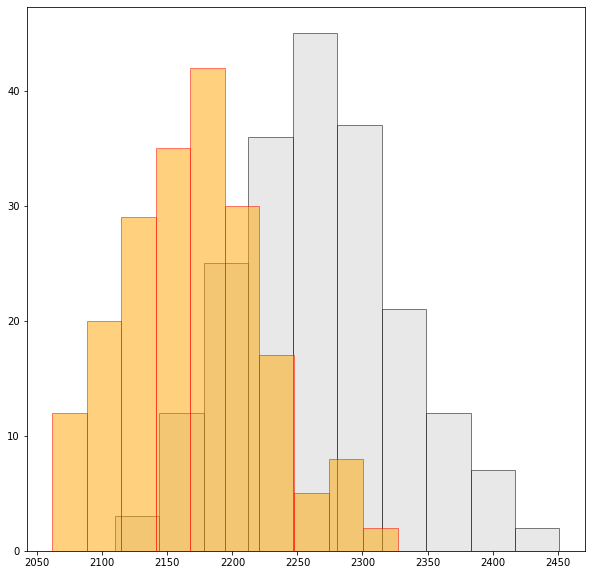

In [213]:

gg_simulati_dic = sim_gg_misti.tail(1).values.tolist()[0]

plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = .5 , bins = 10 )
plt.hist(gg_simulati_dic, color = "orange", edgecolor = "red", alpha = 0.5, bins = 10 )

In [214]:
# intrvallo di confidenza
gg_simulati_dic.sort() 
xs = [round(x) for x in gg_simulati_inizio] 
  
print("minimo", xs[0] , " -  massimo", xs[nsim-1], "gradi giorno")
print("mediana: ", xs[nsim//2] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[nsim-5], "gradi giorno")

minimo 2110  -  massimo 2451 gradi giorno
mediana:  2264 gradi giorno
intervallo di confidenza al 90%:  2148  -  2410 gradi giorno


## Simulazione dei consumi energetici

### scatter plot temperature / consumi 

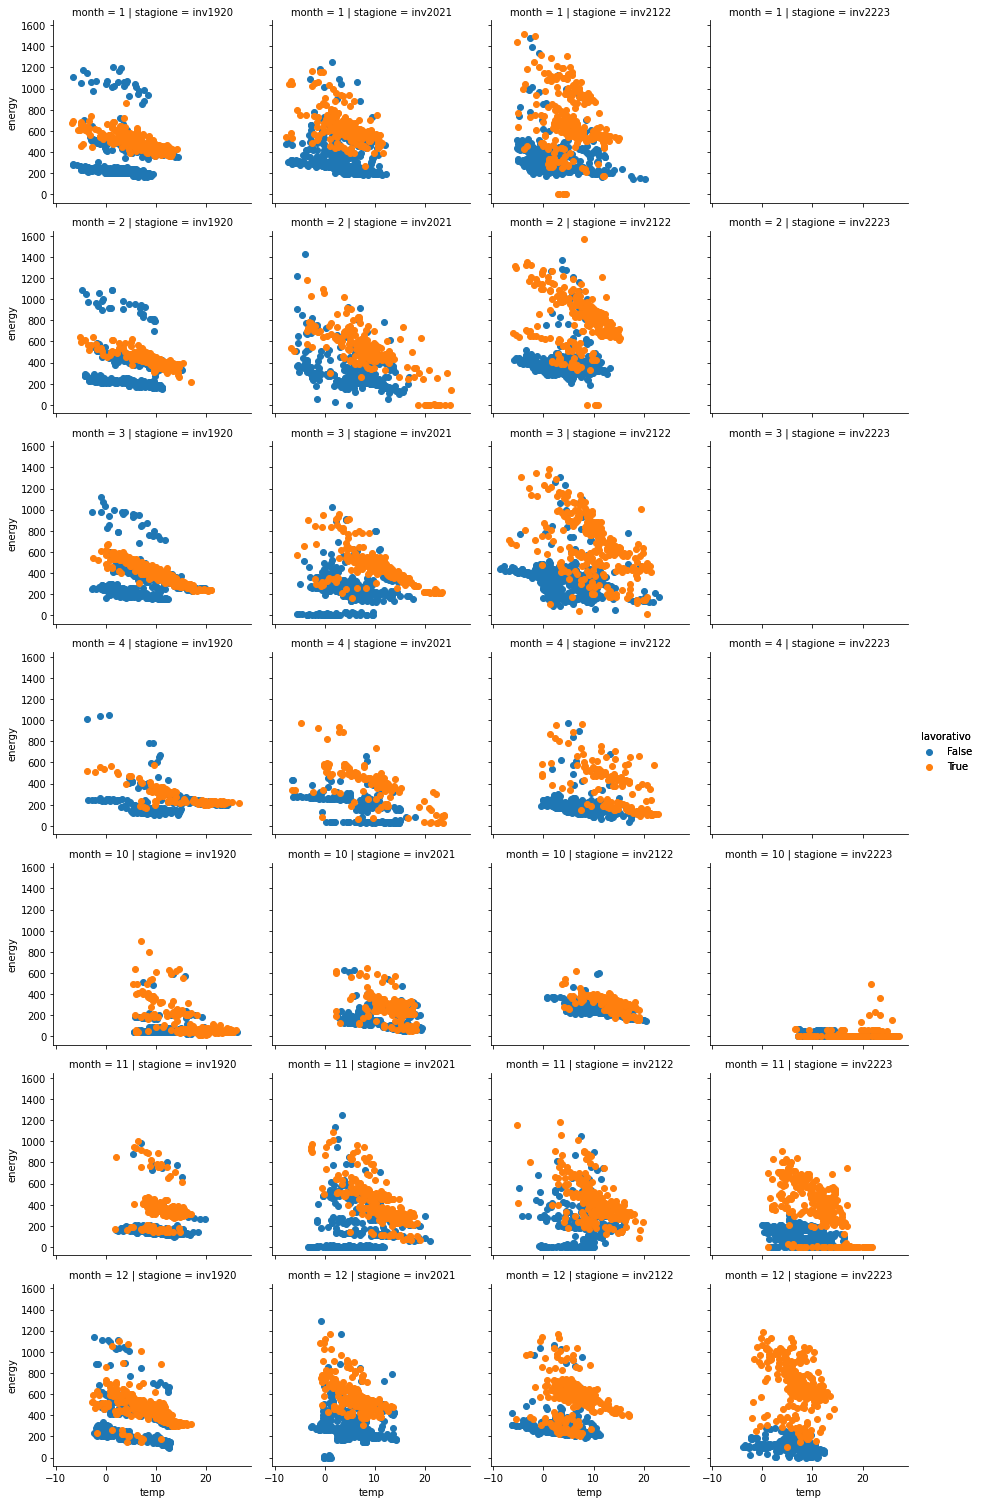

In [215]:
dplot = data[ data.stagione != "-" ]
dplot = dplot[ dplot.stagione != "inv1819" ]
dplot = dplot[["temp", "energy","stagione", "year", "month","ferie",'lavorativo']]
g = sns.FacetGrid(dplot, col="stagione",  row="month", hue='lavorativo').add_legend()
g = g.map(plt.scatter, "temp", "energy").add_legend()
plt.show()

### modello regressione lineare 
dataset di apprendimento: dal 1 novembre al 20 dicembre 2022

In [216]:
dplot = data[ data.stagione == "inv2223" ]

gg_validi_nov = (dplot.month == 11) & (dplot.dd >= 7) 
gg_validi_dic = (dplot.month == 12) & (dplot.dd <= 24) 
dplot = dplot[ gg_validi_nov | gg_validi_dic ]

dplot = dplot[["temp", "energy","stagione", "year", "month", "dd", "ferie",'lavorativo']]
# g = sns.FacetGrid(dplot, col="month",  row="dd", hue='lavorativo').add_legend()
# g = g.map(plt.scatter, "temp", "energy").add_legend()

In [217]:
# data_learn = data[ data.stagione == "inv2223" ]
# gg_validi_nov = (data_learn.month == 11) & (data_learn.dd >= 7)  
# gg_validi_dic = (data_learn.month == 12) & (data_learn.dd <= 24)  
# data_learn = data_learn[ gg_validi_nov | gg_validi_dic ]
# plt.scatter(data_learn.temp, data_learn.energy, c=data_learn.lavorativo, alpha = 0.5)
# data_learn.to_csv('data_learn.csv')

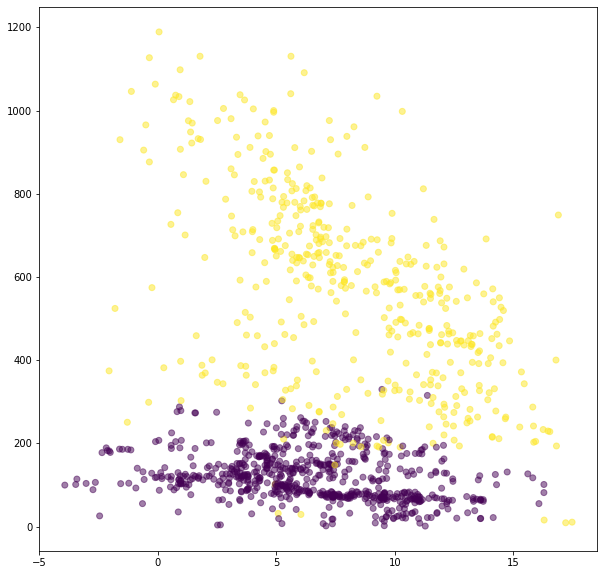

In [218]:
data_learn = data[ data.stagione == "inv2223" ]
gg_validi_nov = (data_learn.month == 11) & (data_learn.dd >= 7)  
gg_validi_dic = (data_learn.month == 12) & (data_learn.dd <= 24)  
data_learn = data_learn[ gg_validi_nov | gg_validi_dic ]
# data_learn = data_learn[ data_learn.hh != 6 ]
# data_learn = data_learn[ data_learn.hh != 18 ]
data_learn = data_learn[ data_learn.energy > 1.0 ]

# filtro_outlier_lav =    (data_learn.lavorativo == True) & (data_learn.energy > 200.0) 
# filtro_outlier_nonlav = (data_learn.lavorativo == False) & (data_learn.energy < 200.0)  
# data_learn = data_learn[ filtro_outlier_lav | filtro_outlier_nonlav ] 

plt.scatter(data_learn.temp, data_learn.energy, c=data_learn.lavorativo, alpha = 0.5)
data_learn.to_csv('data_learn.csv')
  

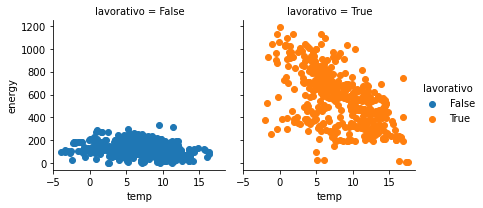

In [219]:
datalr = data_learn

datalr = datalr[["temp", "energy","year", "month", 'lavorativo']]

g = sns.FacetGrid(datalr, col=  "lavorativo", hue = "lavorativo")
g = g.map(plt.scatter, "temp", "energy").add_legend()

In [220]:
import numpy as np
from sklearn.linear_model import LinearRegression



def linreg(data):
    model = LinearRegression()
    
    X = data['temp'].values.reshape(-1, 1)
    y = data['energy'].values

    model.fit(X, y)
    
    score = model.score(X, y)
    coeff = round(model.coef_[0],3)
    intercept = round(model.intercept_,3)
    
    y_pred = model.predict(data[['temp']])
    
    plt.figure()
    ax = data.plot.scatter(x='temp', y='energy', alpha=.5, c="gray")
    ax.plot(X, y_pred, c='black')
    plt.show()

    return( coeff, intercept, score, model)
  




c:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


<Figure size 720x720 with 0 Axes>

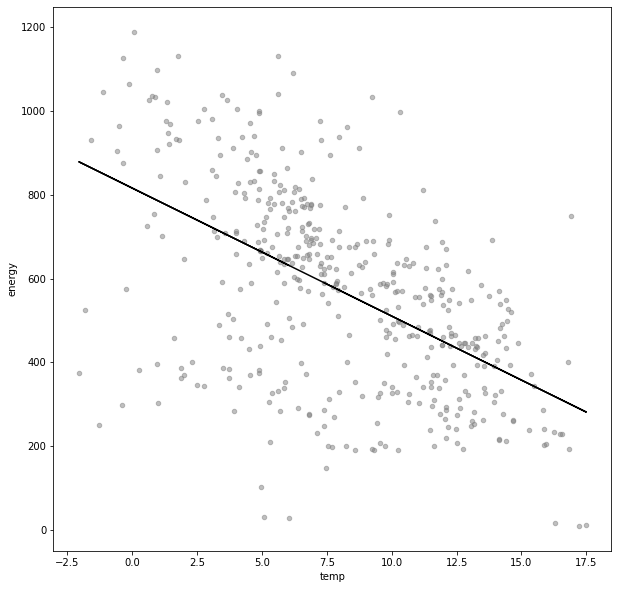

Coefficienti di regressione:  -30.551 816.202
errore quadratico medio:  0.2932350432688968


c:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


<Figure size 720x720 with 0 Axes>

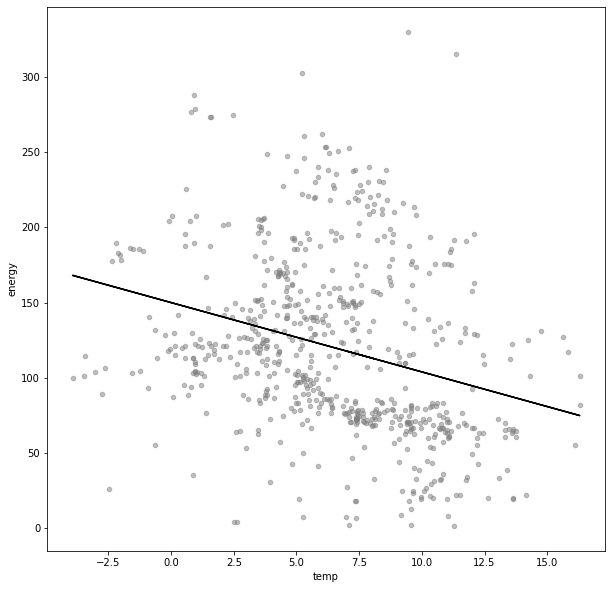

Coefficienti di regressione:  2 150.074
errore quadratico medio:  0.08176945402040903


In [221]:
datalr1 = data_learn[ data_learn.lavorativo == True]
c1, int1, mse1, mod1 = linreg(datalr1)
print("Coefficienti di regressione: ",c1, int1)
print("errore quadratico medio: ", mse1)
plt.show()

datalr2 = data_learn[ data_learn.lavorativo == False]
c2, int2, mse2, mod2 = linreg(datalr2)
print("Coefficienti di regressione: ",2, int2)
print("errore quadratico medio: ", mse2)
plt.show()


sim1 2432261.0 479493.0


<Figure size 720x720 with 0 Axes>

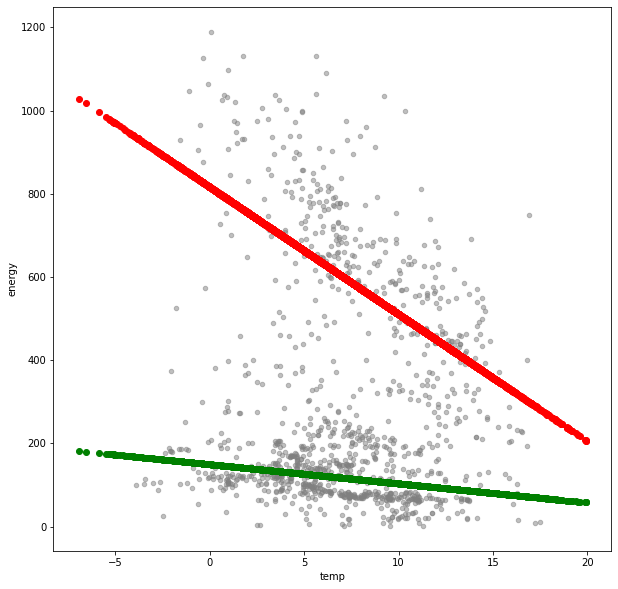

sim2 2545142.0 494713.0


<Figure size 720x720 with 0 Axes>

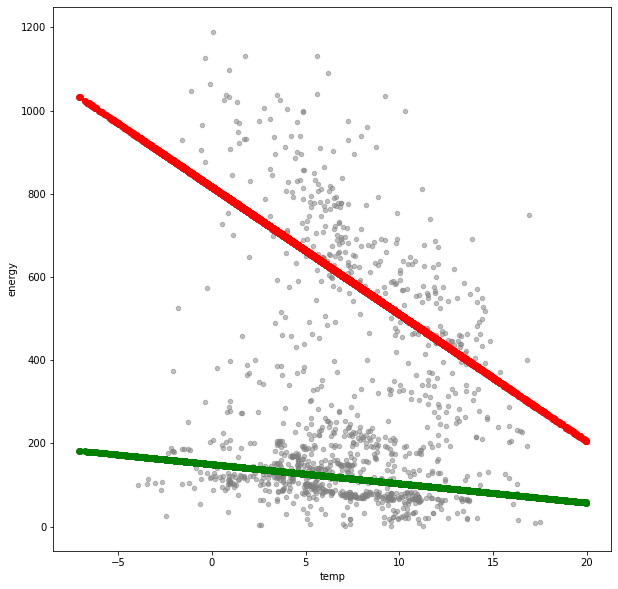

In [222]:

for i in range(0,2):
    temps = tempinv_sim[cols[i]]
    temps = temps[ temps < 20.0].copy()
    temps = temps.values.reshape(-1, 1)
    p1 = mod1.predict(temps) 
    p2 = mod2.predict(temps) 
    print(cols[i], p1.sum().round(), p2.sum().round())
    plt.figure()
    ax = datalr.plot.scatter(x='temp', y='energy', alpha=.5, c = "gray")
    ax.scatter(temps, p1, c = "red")
    ax.scatter(temps, p2, c = "green")
    plt.show()

0.38858695652173914


0.8310326300949336

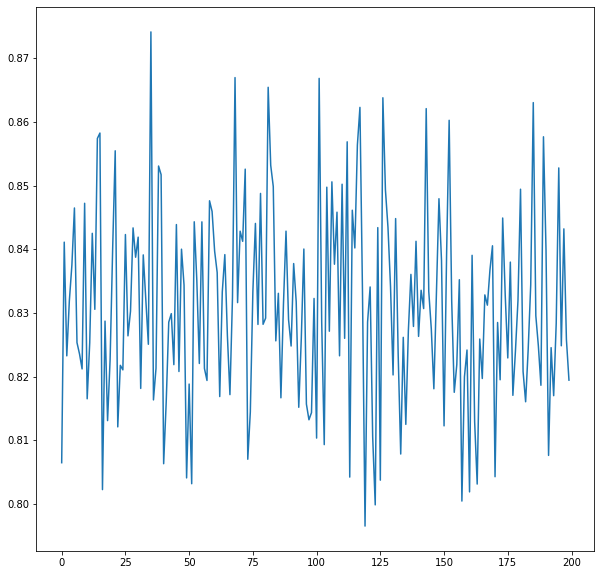

In [223]:
stag = "inv2021"
energy1 = []
energy2 = []
fraction = data[ data.stagione == stag].lavorativo.mean()
print(fraction)
results = []
for i in range(0,nsim):
    temps = tempinv_sim[cols[i]]
    temps = temps[ temps < 20.0].copy()
    temps = temps.values.reshape(-1, 1)
    p1 = mod1.predict(temps) /1000000
    p2 = mod2.predict(temps) /1000000
    energy1.append(p1.sum())
    energy2.append(p2.sum())
    real = data[ data.stagione == stag ].energy.sum()/1000000
    simulated = fraction * p1.sum()+ (1-fraction)*p2.sum()
    results.append(simulated/real)
# plt.plot(energy1)
# plt.plot(energy2)
plt.plot(results)
np.mean(results)




0.3877504553734062


0.8928314560329396

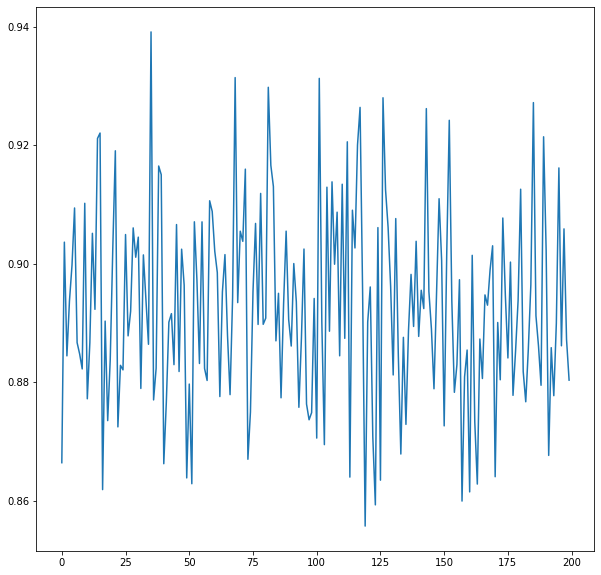

In [224]:
stag = "inv1920"
energy1 = []
energy2 = []
fraction = data[ data.stagione == stag].lavorativo.mean()
print(fraction)
results = []
for i in range(0,nsim):
    temps = tempinv_sim[cols[i]]
    temps = temps[ temps < 20.0].copy()
    temps = temps.values.reshape(-1, 1)
    p1 = mod1.predict(temps) /1000000
    p2 = mod2.predict(temps) /1000000
    energy1.append(p1.sum())
    energy2.append(p2.sum())
    real = data[ data.stagione == stag ].energy.sum()/1000000
    simulated = fraction * p1.sum()+ (1-fraction)*p2.sum()
    results.append(simulated/real)
# plt.plot(energy1)
# plt.plot(energy2)
plt.plot(results)
np.mean(results)

In [225]:
datalr.to_csv("dat.csv")

## validazione


In [226]:
# consumi MISURATI vs STIMATI

stag_selezionata = "inv2223"
lavorativo = data.lavorativo[ data.stagione == stag_selezionata].values

temp_misurate = tempinv[stag_selezionata].astype(float).dropna().values.reshape(-1, 1)
limite = len(temp_misurate) 

en_mis = data.energy[ data.stagione == stag_selezionata].values /1000
en_mis = en_mis[0:limite]

en_sim_1 = mod1.predict(temp_misurate) /1000
en_sim_2 = mod2.predict(temp_misurate) /1000

en_sim_tot_1 = en_sim_1.sum().round()
en_sim_tot_2 = en_sim_2.sum().round()

en_sim = []
for i in range(0,limite):
    
    if lavorativo[i]:
        en_sim.append(en_sim_1[i]) 
    else:
        en_sim.append(en_sim_2[i])
    #print(i, en_mis[i], en_sim[i])
        



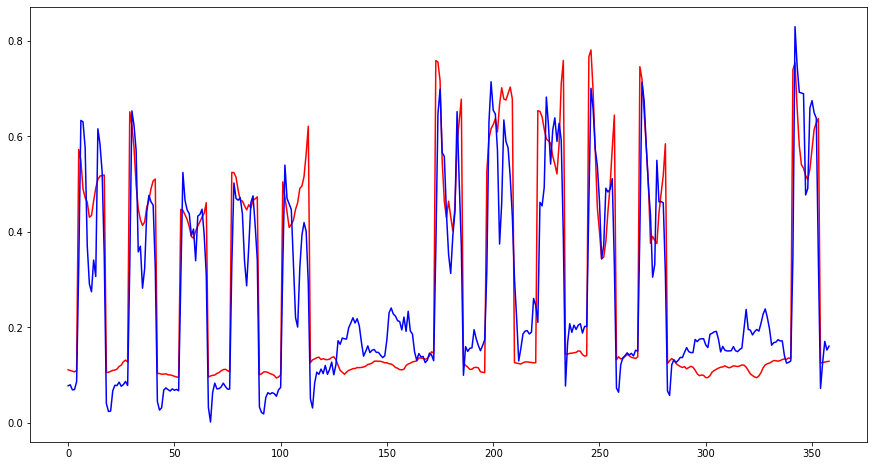

In [227]:
# taglia i primi 800 punti: impianti spenti
ntail = 30
en_sim_tail = en_sim[24*ntail:]
en_mis_tail = en_mis[24*ntail:]

ggvis = 15

plt.figure( figsize=(15,8))
# plt.plot(en_sim_1, c = "gray") 
# plt.plot(en_sim_2, c = "yellow") 



plt.plot(en_sim_tail[1:(24*ggvis)], c = "red")  # SIMULATO
plt.plot(en_mis_tail[1:(24*ggvis)], c = "blue") # MISURATO



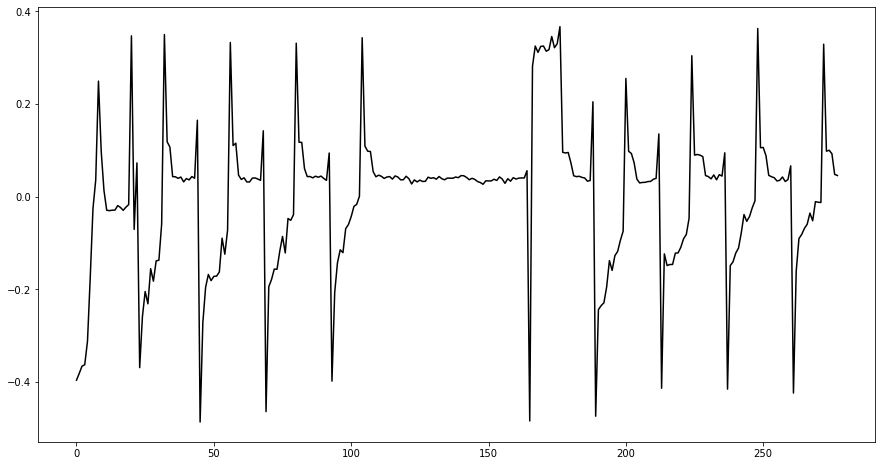

In [228]:
eee = (en_sim_tail - en_mis_tail)
plt.figure( figsize=(15,8))
plt.plot(eee [850:1200], c = "black")
 

In [229]:
et_sim = round(sum(en_sim_tail),2)
et_mis = round(sum(en_mis_tail),2)
err = round( (et_sim-et_mis)/et_mis*100,3)
print("Valore misurato: ", et_mis)
print("Valore simulato: ", et_sim)
print("Errore: ", err, "%")


Valore misurato:  350.66
Valore simulato:  347.87
Errore:  -0.796 %


In [230]:
tmp = en_sim_tail/en_mis_tail
df = pd.DataFrame()
df['mis'] = en_mis_tail
df['sim'] = en_sim_tail
df["err"] = (df.sim-df.mis)
df

<ipython-input-230-3101fc13ccf1>:1: RuntimeWarning: divide by zero encountered in true_divide
  tmp = en_sim_tail/en_mis_tail


,mis,sim,err
0,0.0835,0.109062,0.025562
1,0.0775,0.110905,0.033405
2,0.0795,0.109569,0.030069
3,0.0690,0.108048,0.039048
4,0.0695,0.106666,0.037166
...,...,...,...
1123,0.0020,0.100215,0.098215
1124,0.0000,0.100215,0.100215
1125,0.0075,0.100215,0.092715
1126,0.0520,0.100215,0.048215


## identificazione outliers
Utilizzando DBSCAN (density based clustering) identifico diversi cluster e in particolare il cluster "-1" halo cioè outlier
Può essere sufficiente il calcolo delle distanze nel dataset normalizzato: i punti oltre il 90° percentile sono outlier

In [231]:
def normalize(X):
    X[:,0] = (X[:,0] - X[:,0].mean())/X[:,0].std()
    X[:,1] = (X[:,1] - X[:,1].mean())/X[:,1].std()
    return(X)

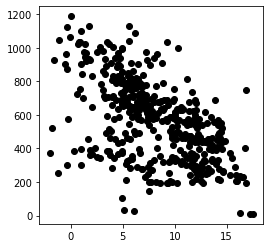

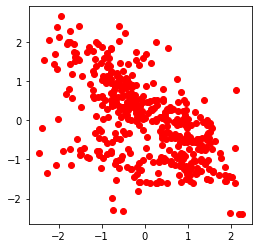

In [232]:
data_cluster = data_learn[ data_learn.lavorativo == True] 
X = data_cluster.loc[ :, ['temp', 'energy']].values
plt.rcParams['figure.figsize'] = (4,4)
plt.scatter(X[:,0], X[:,1], color = "black")
plt.show()
Xn = normalize(X)
plt.rcParams['figure.figsize'] = (4,4)
plt.scatter(Xn[:,0], Xn[:,1], color = "red")
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

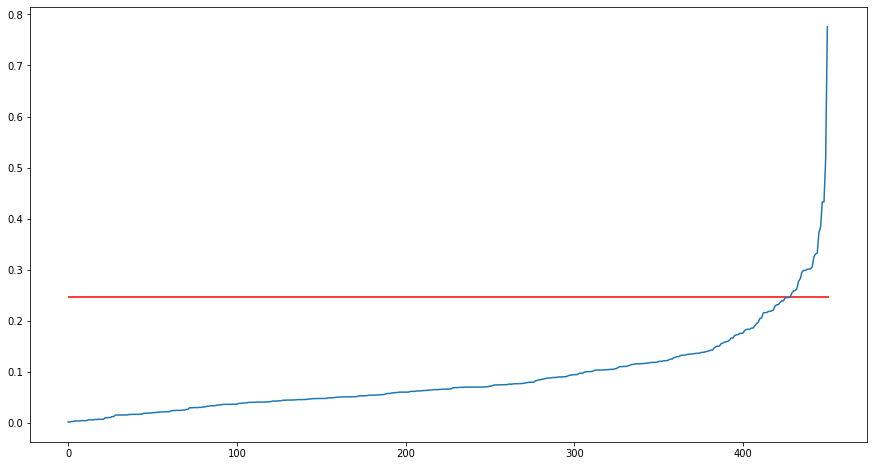

In [233]:
from sklearn.neighbors import NearestNeighbors
neighb = NearestNeighbors(n_neighbors=2)
nbrs = neighb.fit(Xn)
distances, indices = nbrs.kneighbors(Xn)
distances = np.sort(distances, axis = 0)
distances = distances[:,1] #second column
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(distances)
limx = round(len(distances)*0.95)
limy = np.sort(distances)[limx]

plt.hlines(y=limy, xmin= 0, xmax=len(distances),color="red")
plt.show

frazione di punti identificati come halo


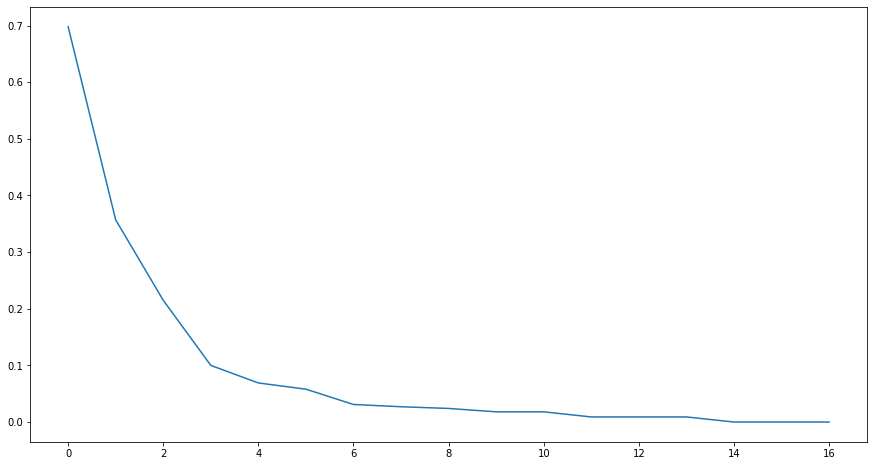

In [234]:
from sklearn.cluster import DBSCAN
print("frazione di punti identificati come halo")
result = []
for epsilon in np.arange(0.1, 0.95, 0.05):
    clustering = DBSCAN(eps=epsilon, min_samples=5).fit(Xn)
    #print(round(epsilon,3), (clustering.labels_ == -1).mean().round(3))
    result.append( (clustering.labels_ == -1).mean().round(3) )
    # plt.scatter(X[:,0], X[:,1], color = clustering.labels_)
    # plt.show()
plt.plot(result)
    
 

In [235]:
# clustering = DBSCAN(eps=0.30, min_samples=5).fit(Xn)

# Xc = Xn[clustering.labels_ >= 0] # points belong to some cluster
# Xh = Xn[clustering.labels_ <  0] # points belong to HALO

# plt.rcParams['figure.figsize'] = (10,10)
# plt.scatter(Xc[:,0], Xc[:,1], c = clustering.labels_[clustering.labels_ >= 0])
# plt.scatter(Xh[:,0], Xh[:,1], color = "lightgray")


In [236]:
def outliers(X, epsilon, minpoints):
    clustering = DBSCAN(eps=epsilon, min_samples=minpoints).fit(X)

    Xc = X[clustering.labels_ >= 0] # points belong to some cluster
    Xh = X[clustering.labels_ <  0] # points belong to HALO

    plt.rcParams['figure.figsize'] = (10,10)
    plt.scatter(Xc[:,0], Xc[:,1], c = clustering.labels_[clustering.labels_ >= 0])
    plt.scatter(Xh[:,0], Xh[:,1], color = "lightgray")
    
    return(clustering.labels_[clustering.labels_ >= 0])

 

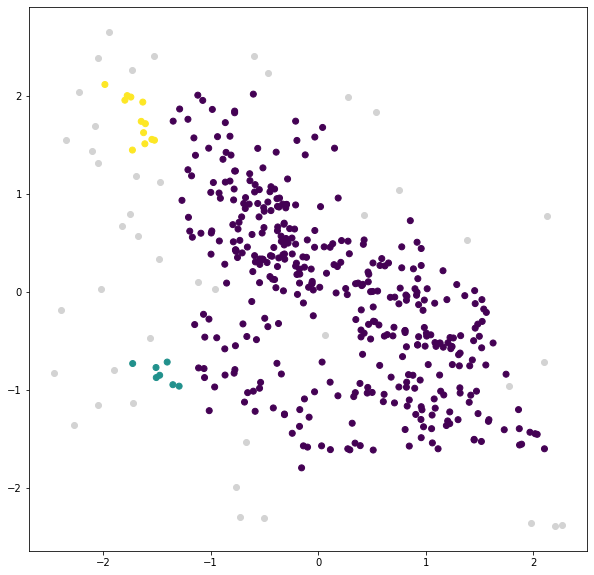

In [237]:
X = data_learn[ data_learn.lavorativo == True].loc[ :, ['temp', 'energy']].values
outliers_list_lav = outliers(normalize(X), epsilon = 0.25, minpoints=4)

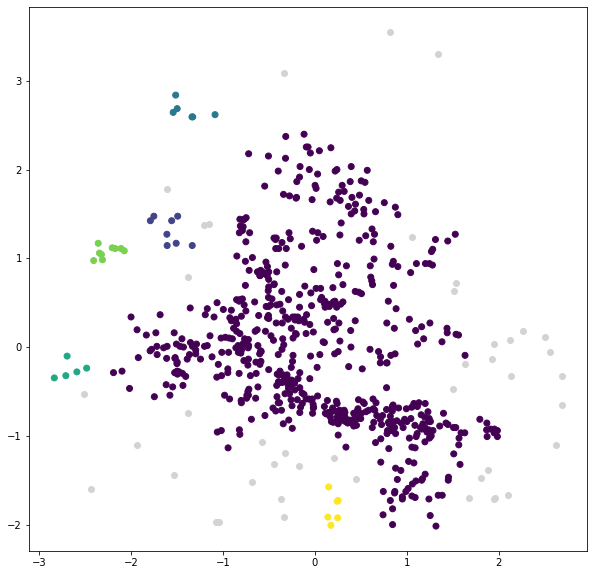

In [238]:
K = data_learn[ data_learn.lavorativo == False].loc[ :, ['temp', 'energy']].values
outliers_list_nonlav = outliers(normalize(K), epsilon = 0.25, minpoints=4)

TO DO
distinguere 3 fasce orarie
- giorno lavorativo 7.18
- giorno weekend e festivo 7-18
- notti 19-6